In [3]:
import torch
from torch_geometric.data import Data
import networkx as nx
from torch_geometric import utils
import pandas as pd

In [22]:
def cg_processing(df: pd.DataFrame):
    df["type_pre_eff"] = df["type_pre_eff"].astype(int)
    df["type_eff_eff"] = df["type_eff_eff"].astype(int)
    return df

In [26]:

cg1 = pd.read_csv('cgs/cg1_cg.csv', header=0)
cg1 = cg_processing(cg1)
cg2 = pd.read_csv('cgs/cg2_cg.csv', header=0)
cg2 = cg_processing(cg2)
cg3 = pd.read_csv('cgs/cg3_cg.csv', header=0)
cg3 = cg_processing(cg3)

df = cg2

# get sas file
# generate variables and cg
# insert into grapgh variables features [3,4,1,....]
# insert into grapgh edges
# insert into grapgh edge labels

with open("cgs/current_test.txt") as file:
    lines = file.readlines()

# lines = list(map(lambda x: x.split(" ")[0:2], lines))
# lines = list(map(lambda x: (int(x[0]), int(x[1])), lines))
edges_and_types = map(lambda x: [int(character) for character in x.split(" ")[0:4]], lines)
edges_and_types = list(edges_and_types)

edges = []
edge_types = []
for edge_out, edge_in, feature in edges_and_types:
    edges.append((edge_out, edge_in))
    edge_types.append(feature)

target_variable = map(lambda x: 0 if x.split(" ")[3].strip() == "False" else 1, lines)
target_variable = list(target_variable)

data = Data(
    edge_index=torch.tensor(edges, dtype=torch.long).t().contiguous(),
    edge_attr=[len(edges), 1],
    y=target_variable
)

df_edges = df[["source", "destination"]].values
df_label = df["label"].values
df_features = df[["type_pre_eff", "type_eff_eff"]].values


data = Data(
    edge_index=torch.tensor(df_edges, dtype=torch.long).t().contiguous(),
    edge_attr=torch.tensor(df_features, dtype=torch.long),
    y=df_label,
)




In [32]:
data.edge_attr[0]
data.y[2]
df.head()


False

In [29]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

,source,destination,type_pre_eff,type_eff_eff,label
0,5,7,1,0,True
1,3,7,1,1,True
2,1,6,1,1,False
3,4,6,1,0,False
4,2,3,1,1,True


/Users/bartoszlachowicz/Desktop/CodeProjects/GraphNeuralNetworks-ICAPS/.venv/lib/python3.9/site-packages/torch_geometric/data/storage.py:271: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_attr', 'edge_index', 'y'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


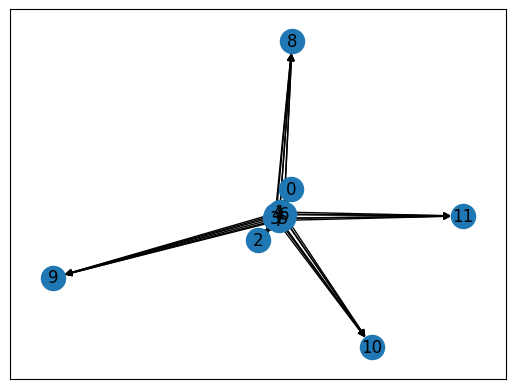

In [33]:
g = utils.to_networkx(data)

a = nx.draw_networkx(g)

In [60]:
lin.weight[0][0] + 2*lin.weight[0][1]

tensor(-0.7890, grad_fn=<AddBackward0>)

In [56]:
lin = torch.nn.Linear(2,1, bias=False)
lin.weight

Parameter containing:
tensor([[ 0.0105, -0.3998]], requires_grad=True)

In [57]:
d1 = [1,2]
d2 = [3,4]
d3 = [5,6]
d4 = [7,8]

# [4 x [2,1]]

data = torch.tensor([d1,d2,d3,d4], dtype=torch.float)
data.shape

torch.Size([4, 2])

In [58]:
lin(data)

tensor([[-0.7890],
        [-1.5675],
        [-2.3460],
        [-3.1245]], grad_fn=<MmBackward0>)

In [69]:
import torch
import torch_geometric
from torch_geometric.nn import MessagePassing
class SrcDstMean(MessagePassing):
    """Calculates mean of one feature along the edges."""
    def init(self):
        super().init(aggr="mean", flow="source_to_target")
    def forward(self, x, edge_index):
        return self.propagate(edge_index=edge_index, x=x)
    def message(self, x_i, x_j, edge_index, size):
        print(x_i)
        # return  torch.stack([x_i, x_j**2], dim=1)
    def update(self, aggr_out):
        return aggr_out + 2333
    

sdmean = SrcDstMean()
index_arr = torch.LongTensor([[0,1,2,3,4], [1,2,3,4,5],])
x = torch.Tensor([z**2+100. for z in range(6)])
x
# res = sdmean(x=x, edge_index=index_arr)

tensor([100., 101., 104., 109., 116., 125.])

In [100]:
import json

first_object = {
    "imie": "bartek",
    "wiek": 12,
    "is_gay": False
}

second_object = {
    "imie": "Kasia",
    "wiek": 14
}

third_object = {
    "imie": "Maciek",
    "wiek": 16,
}

lista_obiektow = [first_object, second_object, third_object]


with open("nowy.json", "w") as file:
    json.dump(lista_obiektow, file)

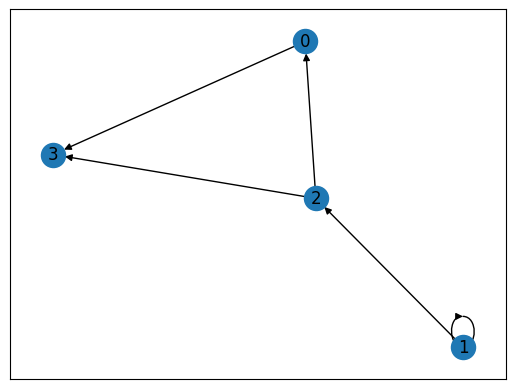

In [19]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[1, 2, 1, 2, 0],
                           [1, 0, 2, 3, 3]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1], [1.1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
g = utils.to_networkx(data)

a = nx.draw_networkx(g)